# Code for the paper "The Least Balanced Graphs and Trees"

by Péter Csikvári and Viktor Harangi

In [1]:
import numpy as np
from numpy.linalg import eigh,inv
from sage.graphs.trees import TreeIterator

Ga_conn=0.5*(3*sqrt(3.)+5)  # ~5.098 
Ga_tree=4+2*sqrt(3.)        # ~7.4641 
q=lambda x: x/2-sqrt((x/2)^2-1)
r=lambda x: x/2+sqrt((x/2)^2-1)
t = polygen(ZZ,'t')
la_var = polygen(ZZ,'\u03BB')
ka_var = polygen(ZZ,'\u03BA')

def principal_ev(A):
    evals,evecs=eigh(A)
    ind=np.argmax(evals)
    la=evals[ind]
    vec=evecs[:,ind]
    return la,vec if vec[0]>=0 else -vec

def lambda_G(G):
    return principal_ev(G.adjacency_matrix())[0]

def Gamma(vec):
    return sum(vec)^2/sum(vec^2)

def GammaA(A):
    return Gamma(principal_ev(A)[1])

def GammaG(G):
    return GammaA(G.adjacency_matrix())

def draw_graph(G,colored_vertices=[],title=None):
    G.graphplot(title=title,graph_border=(title!=None),layout='spring', iterations=1000,vertex_colors={'lightblue':colored_vertices}).show(figsize=2+0.5*G.diameter())
        
def possible_root(G,v,tree_version=False):
    if G.degree(v)<3:
        return False
    if tree_version:
        return True
    for u in G.vertices():
        if G.degree(u)>G.degree(v) and all(u==w or G.has_edge(u,w) for w in G.neighbors(v)):
            return False
    return True

# generate the possible n-kernels
# (rooted conn.graphs/trees on n vertices such that the root has degree >= 3 and is not "dominated" by another vertex)
def generate_kernels(n,only_trees=False):
    rooted_graphs=[]
    it=TreeIterator(n) if only_trees else graphs.nauty_geng('-c {}'.format(n))
    for G in it:
        orbs=G.automorphism_group().orbits()
        for orb in orbs:
            root=orb[0]
            if possible_root(G,root,only_trees):
                rooted_graphs.append((G,root))
    print("{} rooted {} found on {} vertices".format(len(rooted_graphs),"trees" if only_trees else "graphs",n))
    return rooted_graphs

#def V_act(G,root,use_lvl0_extension=False):
#    levels=[[] for _ in range(4)]
#    for v in G.vertices():
#        levels[G.distance(root,v)].append(v)        
#    if use_lvl0_extension:
#        levels[0]+=[v for v in levels[1] if all(u==v or G.has_edge(u,v) for u in levels[1])]
#        levels[1]=[v for v in levels[1] if v not in levels[0]]
#    return levels[3]+levels[2] if len(levels[3])>0 else levels[2]+levels[1]

def power_set(S,item_excl=None,exclude_empty=True):
    subsets = [[]]
    for item in S:
        subsets += [ss+[item] for ss in subsets]
    if item_excl!=None:
        i=S.index(item_excl)
        subsets.pop(2^i)
    if exclude_empty:
        subsets.pop(0)
    return subsets

def glue(G0,v,G1,u=0):
    n=G0.order()
    G1.relabel({i:n+i for i in range(G1.order())})
    G=G0.union(G1)
    G.add_edge(v,n+u)
    return G

def unifork(n):
    G=graphs.PathGraph(n-1)
    add_leaf(G,1)
    return G

def bifork(n):
    G=graphs.PathGraph(n-2)
    add_leaf(G,1)
    add_leaf(G,n-4)
    return G

def add_path(G,k,v=None):
    n=G.order()
    if v==None:
        v=n-1
    G.add_edge(v,n)
    for i in range(k-1):
        G.add_edge(n+i,n+i+1)

def add_leaf(G,v=None):
    add_path(G,1,v)

# our bound on Gamma in terms of the degree of the master vertex
def beta_deg(d,show_plot=False):
    sqd=sqrt(d+0.)
    la_deg=find_root((x+1)^3-(d+1)*(3*x+1),sqd,2*sqd)
    fun=lambda x: x/(1-(d+1)/(x+1)^2)
    if show_plot:
        show( point((la_deg,fun(la_deg)),color='red')+plot(fun,sqd,2*sqd) )
    return fun(la_deg)

beta_d_map={i: beta_deg(i) for i in range(3,21)}

# sort n-vertex conn.graphs/trees in a descending order of their Gamma
# displays the first display_nr graphs
def ranking(n,only_trees=False,display_nr=10):
    it=TreeIterator(n) if only_trees else graphs.nauty_geng('-c {}'.format(n))
    Gas=[(G,GammaG(G)) for G in it]
    Gas_sorted=sorted(Gas, key=lambda pair: pair[1])

    if display_nr>0:
        str="trees" if only_trees else "connected graphs"
        print("{}-vertex {} with the smallest Gamma:".format(n,str))
        for pair in Gas_sorted[:display_nr]:
            draw_graph(pair[0])
            print(pair[1])
        print("---------------------------------------------------------")

    return Gas_sorted

# locates a root of the function 'fun' that should be positive at 'start' 
# (useful when the root may be very close to 'start') 
def find_r(fun,start,step=1./16,prec=0.5^20):
    assert fun(start)>0
    while fun(start+step)>=0:
        start+=step
    end=start+step
    while end-start>prec:
        mid=0.5*(start+end)
        if fun(mid)>=0:
            start=mid
        else:
            end=mid
    return start,end

# checks whether the coefficients of a (translated) polynomial are all positive
def check_coeffs(pol,t0=0):
    trans_pol=pol if t0==0 else pol(t+t0)
    return all(co>=0 for co in trans_pol.coefficients())
    
def true_minimum(num,denum,t0,delta=2.):
    fun=lambda x: num(x)/denum(x)
    val0=fun(t0)
    diff_pol=num-val0*denum
    while all(co>=0 for co in diff_pol(t+t0+delta).coefficients()):
        delta/=2
    t1=t0+2*delta
    val=find_local_minimum(fun,t0,t1)[0]
    return min(val,fun(t0),fun(t1))


class Kernel:
    def __init__(self, H, root=0, Ga_target=0,tree_mode=False):
        self.H=H.copy()
        self.root=root
        self.tree_mode=tree_mode
        self.Ga_target=Ga_target # target ratio (beta)
        
        if self.Ga_target<=0:
            self.Ga_target=Ga_tree if self.tree_mode else Ga_conn

        self.n=self.H.order() # nr of vertices
        self.A=self.H.adjacency_matrix() # adjacency matrix
        mat=la_var*matrix.identity(self.n)-self.A # lambda*I-A
        self.P=mat.det() # char-poly of A
        self.adj=mat.adjugate() # adjoint(tI-A)=P(tI-A)^{-1}=PB
        self.la_H,self.xx=principal_ev(self.A) # top eigval and principal eigvec
        self.Ga_H=Gamma(self.xx) # Gamma_H = Gamma(x)
        
        self.active=list(range(self.n)) # set of active vertices
        
        self.A_ext=np.zeros((self.n+1,self.n+1)) # an auxiliary matrix of size (n+1)x(n+1)
        self.A_ext[:-1,:-1]=self.A
        

    def draw(self,with_root=True,title=None):
        draw_graph(self.H,[self.root] if with_root else [],title)
    
    def la_U(self,U,Gamma_version=False):
        row=np.zeros(self.n+1)
        row[U]=1
        self.A_ext[-1]=row
        self.A_ext[:,-1]=row
        la,vec=principal_ev(self.A_ext)
        if Gamma_version:
            return Gamma(vec)
        else:
            return la
    
    def default_active(self):
        dists=[self.H.distance(self.root,v) for v in range(self.n)]
        dist_max=max(dists)
        self.active=[v for v in range(self.n) if dists[v]>=dist_max-1]
        if self.root in self.active:
            d=self.H.degree(self.root)
            #print(d,beta_d_map[d+1],self.Ga_target)
            if beta_d_map[d+1]>self.Ga_target:
                self.active.remove(self.root)  # we may remove root from active b/c Gamma > beta_{d+1} > Ga_target 
                
    # setting Uc=\mathcal(U) based on the set of active vertices
    # Uc = set of nonempty subsets of active, excluding the one-element set {v_excl} unless v_excl=None 
    # in tree-mode: Uc=one-element subsets of active
    def act_Uc(self,v_excl=None,update=True):
        self.Uc=[[v] for v in self.active] if self.tree_mode else power_set(self.active,v_excl)
        if update:
            self.update_Uc()            
    
    # setting your own Uc (not based on active)
    def set_Uc(self,Uc):
        self.Uc=Uc
        self.update_Uc()
            
    def update_Uc(self):
        self.nr=len(self.Uc) # nr of sets in Uc
        self.las=[0.]*self.nr # list of la_U's for U in Uc
        self.Bt=[None]*self.nr # essentially $P \tilde(B)_{v,U}$ for U in Uc
        self.s=[None]*self.nr # essentially $P s_U$ for U in Uc
        for i in range(self.nr):
            U=self.Uc[i]
            self.las[i]=self.la_U(U)
            self.Bt[i]=sum(self.adj[u] for u in U)
            self.s[i]=sum(self.Bt[i])
    
    # remove sets with given indices from Uc and update las,Bt,s accordingly
    # indices should be in increasing order
    def remove_from_Uc(self,indices):
        for i in reversed(indices):
            self.Uc.pop(i)
            self.las.pop(i)
            self.Bt.pop(i)
            self.s.pop(i)
        self.nr=len(self.Uc)
            
    # returns lambda and Gamma of H +_v P_infty (infinite path attached to H at v) 
    def ev_infty(self,v):
        if self.la_H<2:
            if self.n>8:
                ngh=self.H.neighbors(v)
                if len(ngh)==1 and self.H.degree(ngh[0])==2:
                    return 2.,np.inf  # in this case H must be a path or "unifork" with v being the endpoint
            K_plus=self.augment_kernel([v])
            return K_plus.ev_infty(self.n)
        la_infty=find_root(self.adj[v,v](x)*q(x)==self.P(x),self.la_H,self.n)
        bb=self.adj[v](la_infty)/self.P(la_infty)
        qq=q(la_infty)
        Ga_infty=(sum(bb)+1/(1-qq))^2/(sum(val^2 for val in bb)+1/(1-qq^2))
        return la_infty,Ga_infty

    # checks if Ga_infty <= Ga_target for some active v
    def infty_check(self):
        below_target=False
        for v in self.active:
            la_infty,Ga_infty=self.ev_infty(v)
            if Ga_infty<=self.Ga_target:
                below_target=True
                txt="infinite FAMILY: \u0393\u2192 {:.5f} (at blue vertex {})".format(Ga_infty,v)
                draw_graph(self.H,[v],txt)
        return below_target
    
    # checks condition for bound
    # if returns True, then every Uc-extension of the kernel (H,root) must have Ga_G >= Ga_target
    # if 'diagonal_only' is set to 'True': check the condition only for pairs U=V and saves the indices of failed U's 
    def simple_check(self,diagonal_only=False):
        self.check_fails=[]
        for i1 in range(self.nr):
            i2_bnd=i1+1 if diagonal_only else self.nr
            for i2 in range(i1,i2_bnd):
                lat=max(self.las[i1],self.las[i2]) # \tilde{\lambda}
                cUV=sum(self.Bt[i1][v]*self.Bt[i2][v] for v in range(self.n))
                num=(self.s[i1]+self.P)*(self.s[i2]+self.P)
                denum=cUV+(self.Bt[i1][self.root]+self.Bt[i2][self.root])*self.P/2
                if not check_coeffs(num-self.Ga_target*denum,lat):
                    if diagonal_only:
                        self.check_fails.append(i1)
                    else:    
                        return False
        return len(self.check_fails)==0    

    # returns the augmented/extended kernel obtained by adding a new vertex to H and connecting to 'nghbrs'
    def augment_kernel(self,nghbrs):
        H_plus=self.H.copy()
        for v in nghbrs:
            H_plus.add_edge(v,self.n)
        K_plus=Kernel(H_plus,self.root,self.Ga_target,self.tree_mode)
        K_plus.active=self.active+[self.n]
        K_plus.act_Uc()
        return K_plus
                
    # if returns True, then {v} may be removed from Uc (or v can be removed from active in tree-mode)
    def rule_out_singleton(self,v):
        K_plus=self.augment_kernel([v])
        if K_plus.Ga_H<=self.Ga_target:
            txt="single GRAPH: \u0393={:.5f}".format(K_plus.Ga_H)
            K_plus.draw(False,txt)
        return K_plus.simple_check() 
    
    def two_step_check(self):
        ind=np.argmin([self.la_U([v]) for v in self.active])
        v_min=self.active[ind] # the "minimal" active vertex, for which la_{v} is the smallest 
        print("two-step-check excluding #{} vertex started...".format(v_min))
        step1=self.rule_out_singleton(v_min)
        self.act_Uc(v_min)    
        step2=self.simple_check()
        if step1 and step2:
            print("SUCCESSFUL")
        else:
            print("FAILED!!! step 1:{}  step 2: {}".format(step1,step2))

    # active-vertex-elimination process: checks active vertices one by one to see if they can be removed
    def active_elimination(self):
        assert self.tree_mode
        V=self.active.copy()
        for v in V:
            if self.rule_out_singleton(v):
                self.active.remove(v)

    # if, after active-vertex-elimination, only one active vertex v remains active,
    # then we can continue with an augmented kernel (extended through v)  
    def augment_check(self,n_limit=20):
        if self.n>n_limit:
            print("!!!augment-check FAILED  (vertex nr limit REACHED)")
            return False
        if self.simple_check():
            return True
        print("simple-check with active set {} FAILED for:".format(self.active))
        self.draw()
        print("active-vertex-elimination started...")
        self.active_elimination()
        if len(self.active)==0:
            print("...no active vertex remained!")
            print("augment-check SUCCESSFUL")
            return True
        elif len(self.active)==1:
            v=self.active[0]
            print("...only one active vertex remained --> adding leaf at vertex #{}...".format(v))
            K_plus=self.augment_kernel([v])
            return K_plus.augment_check()
        else:
            print(" ...multiple active vertices remained:",self.active)
            print("!!!augment-check FAILED")
            return False            

    def search(self):
        #print("uc started", self.n)
        if self.infty_check():
            return
        self.simple_check(True)
        U_failed=[self.Uc[i] for i in self.check_fails]
        self.remove_from_Uc(self.check_fails)
        assert self.simple_check()  # the remaining Uc should pass this test (unless "non-diagonal" pairs U!=V cause problems)
        #print("failed sets:",U_failed)
        #print("remaining:",self.Uc)
        for U in U_failed:
            K_plus=self.augment_kernel(U)
            if K_plus.Ga_H<=self.Ga_target:
                txt="single GRAPH: \u0393={:.5f}".format(K_plus.Ga_H)
                K_plus.draw(False,txt)
            K_plus.search()
        return 
        
    # a version of simple-check that displays the necessary steps and computations along the way
    # it also provided plots for comparing the different bounds
    def detailed_check(self,diagonal_only=False):
        print("kernel:")
        self.draw()
        print("Gamma_target:",self.Ga_target)
        print("adjacency matrix:")
        print(self.A)
        print()
        print('P(\u03BB)=',self.P,'\n')
        print('P(\u03BB)B(\u03BB):')
        for row in self.adj:
              print(row)
        print()
        print("active vertices:",self.active)
        print("possible subsets:",self.Uc)
        print("la_H for kernel: {:.4f}".format(self.la_H))
        print()

        la_max=self.la_H+0.2

        self.gas=[self.la_U(self.Uc[i],True) for i in range(self.nr)]

        for i in range(self.nr):
            print("U: {}    \u03BB_U: {:.4f}".format(self.Uc[i],self.las[i]))
            print('P B~_o,U:',self.Bt[i][self.root])
            print('P s_U:',self.s[i])
            print('----------------------------------------------------')

        pt_base=point([(self.la_H,self.Ga_H)], color='black')

        for i1 in range(self.nr):
            i2_bnd=i1+1 if diagonal_only else self.nr
            for i2 in range(i1,i2_bnd):
                lat=max(self.las[i1],self.las[i2])
                cUV=sum(self.Bt[i1][v]*self.Bt[i2][v] for v in range(self.n))
                num=(self.s[i1]+self.P)*(self.s[i2]+self.P)
                denum=cUV+(self.Bt[i1][self.root]+self.Bt[i2][self.root])*self.P/2
                denum_or=cUV+self.P^2 if i1==i2 else cUV
                
                print('U={}   V={}   \u03BB~: {:.4f}'.format(self.Uc[i1],self.Uc[i2],lat))
                print('P^2 c_U,V:',cUV,'\n')

                Q=num-self.Ga_target*denum
                print('Q(\u03BB)=',Q,'\n')
                Qt=Q(ka_var+lat)
                print('Q~(\u03BA)=Q(\u03BB+\u03BB~)=',Qt,'\n')
                print("simple-check", "SUCCESSFUL" if check_coeffs(Qt) else "FAILED")

                fig=plot([num(x)/denum(x),self.Ga_target],self.la_H,la_max)
                fig+=plot(num(x)/denum_or(x),self.la_H,la_max, color='red')
                fig+=line([(lat,num(lat)/denum_or(lat)),(lat,self.Ga_target),(lat,num(lat)/denum(lat))],color='black')
                fig+=pt_base
                if i1==i2:
                    fig+=point([(self.las[i1],self.gas[i1])], color='black')
                fig.show()

    def x_H(self,v,la):
        return self.adj[v](la)/self.P(la)
        
    def tail_check_lower(self,v=None,k0=1):
        if v==None:
            v=self.root
        H0=self.H.copy()
        add_path(H0,k0,v)
        la0=lambda_G(H0)
        la_infty,Ga_infty=self.ev_infty(v)
        print("the relevant interval for \u03BB: I=({:.4f},{:.4f})".format(la0,la_infty))
        
        S=sum(self.adj[v])/self.P
        T=sum(entry^2 for entry in self.adj[v])/self.P^2
        Sh=S(t+1/t)
        Th=T(t+1/t)
        print('S(\u03BB)=',S)
        #print(latex(S))
        print('S^(t)=',Sh)
        #print(latex(Sh))
        print()
        print('T(\u03BB)=',T)
        #print(latex(T))        
        print('T^(t)=',Th)
        #print(latex(Th))        
        print()
        
        Jh=(Sh+t/(t-1))^2/(Th+t^2/(t^2-1))
        print('J^(t)=',Jh)        
        #print(latex(Jh))
        print('J(\u03BB)=J^(r(\u03BB)) should be monotone increasing on I:')            
        plot(Jh(r(x)),la0,la_infty).show()
        
        #cond2_csiki=Th/(Sh+t/(t-1))
        #print(cond2_csiki)
        
        cond2=(Th+1)*t-(Sh+t/(t-1))
        print('f^(t)=(T^(t)+1)t-S^(t)-t/(t-1)=',cond2)
        print('f(\u03BB)=f^(r(\u03BB)) should be positive on I:')
        plot([cond2(r(x))],la0,la_infty).show()
        #fun2=(Th+1)/(Sh+t/(t-1))-1/t
        #plot([fun2(r(x))],la0,la_infty).show()
        
        
# for showing that the tail must be a path
# a path is added to H, then a cherry/triangle is added at the end of the path
# then it is verified that all extensions have Gamma above the limiting ratio 
def tail_check_upper_small(H,path_len,root=0,v=0,triangle=False,tree_mode=False):
    H1=H.copy()
    add_path(H1,path_len,v)
    m=H1.order()
    H1.add_edge(m-1,m)
    H1.add_edge(m-1,m+1)
    if triangle:
        H1.add_edge(m,m+1)        
    K=Kernel(H1,root,0,tree_mode)
    K.draw()

    print(K.Ga_H,">", K.Ga_target, K.Ga_H>K.Ga_target)

    K.active=[m-1,m,m+1]
    K.act_Uc()
    print("extensions > {}: {}".format(K.Ga_target,K.simple_check()))
    

print("limiting ratios:")
print(Ga_conn,"(connected graphs)")
print(Ga_tree,"(trees)")
          
#for H in [graphs.CompleteGraph(4),graphs.StarGraph(4),graphs.StarGraph(5),graphs.StarGraph(3)]:
#    K=Kernel(H)
#    print(K.ev_infty(0))



limiting ratios:
5.09807621135332 (connected graphs)
7.46410161513775 (trees)


## Searching for trees with $\Gamma_T<\Gamma_{\mathrm{target}}$

194 rooted trees found on 10 vertices

Searching for trees with Γ<7.66700:


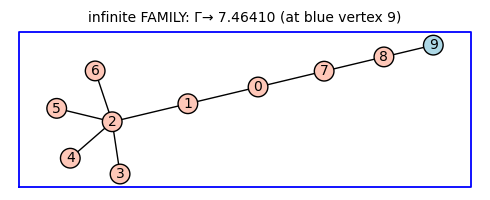

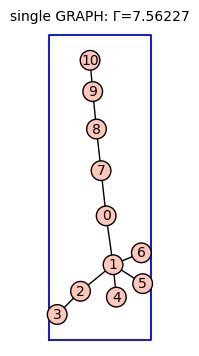

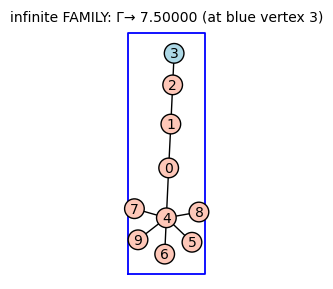

done


In [2]:
#TREES

kernels=generate_kernels(10,only_trees=True)
print()

#Ga_target=Ga_tree
#Ga_target=7.48
#Ga_target=7.55
Ga_target=7.667

print('Searching for trees with \u0393<{:.5f}:'.format(Ga_target))
for H,root in kernels:
    K=Kernel(H,root,Ga_target,tree_mode=True)
    K.default_active()
    K.act_Uc()
    K.search()

print("done")


## Searching for connected graphs with $\Gamma_G<\Gamma_{\mathrm{target}}$

155 rooted graphs found on 6 vertices
Searching for graphs with Γ<5.35000:


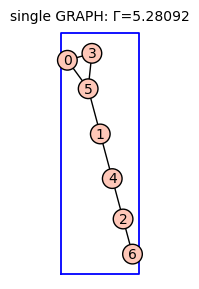

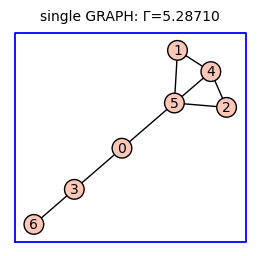

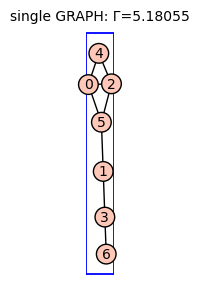

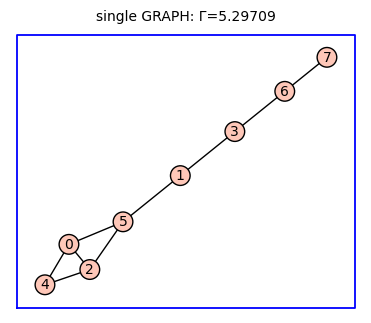

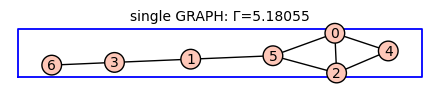

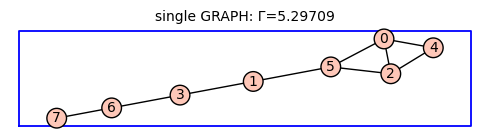

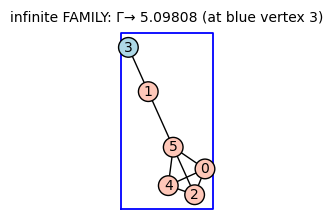

done


In [3]:
#CONNECTED GRAPHS

kernels=generate_kernels(6)

#Ga_target=Ga_conn
#Ga_target=5.18
#Ga_target=5.25
Ga_target=5.35

print('Searching for graphs with \u0393<{:.5f}:'.format(Ga_target))
for H,root in kernels:
    K=Kernel(H,root,Ga_target)
    K.default_active()
    K.act_Uc()
    K.search()
    
print("done")

## Computer checks for trees
The next code performs the checks for ruling out all but one 10-kernel for trees $T$ with $\Gamma_{T}<\beta_{\mathrm{tr}}$. The default value of `Ga_target` is `Ga_tree`$=\beta_{\mathrm{tr}}\approx 7.4641$ but one may set it to a slightly higher value to find more families and single trees below `Ga_target`. 

It runs through all possible 10-kernels (`H`,`root`) of trees and tries to verify the condition that ensures that $\Gamma_T \geq \Gamma_{\mathrm{target}}$ for all extensions $T$ of the kernel. If it fails, it checks whether an infinite pendant path may be attached to `H` such that $\Gamma_{H+P_\infty}<\Gamma_{\mathrm{target}}$. If yes, then there is an infinite family of trees $T$ with $\Gamma_{T}<\Gamma_{\mathrm{target}}$. If no, then it tries to go through the set of active vertices to see if it can rule out some of them. (During this process, it may find single trees $T$ with $\Gamma_{T}<\Gamma_{\mathrm{target}}$.) If no active vertex remains, the process terminates for the current kernel. If only one active vertex remains, then the kernel is augmented by adding a leaf at the remaining active vertex, and the process restarts with this larger kernel. (Again, a single tree with $\Gamma_{T}<\Gamma_{\mathrm{target}}$ may be found at this point.)

194 rooted trees found on 10 vertices
simple-check failed for #25:


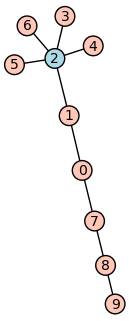

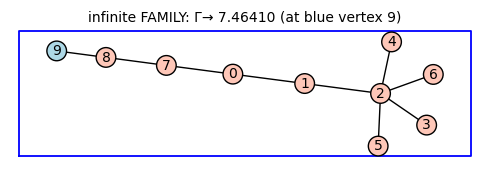

-------------------------------------------------------------------
simple-check failed for #92:


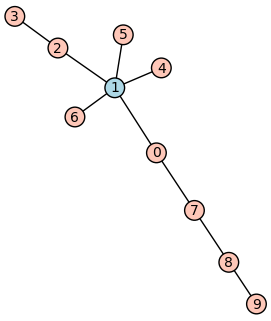

augment-check with active set [8, 9] started...
simple-check with active set [8, 9] FAILED for:


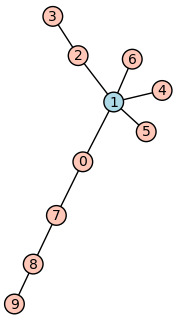

active-vertex-elimination started...
...no active vertex remained!
augment-check SUCCESSFUL
-------------------------------------------------------------------
simple-check failed for #131:


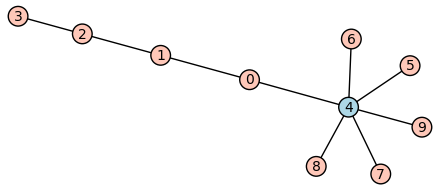

augment-check with active set [2, 3] started...
simple-check with active set [2, 3] FAILED for:


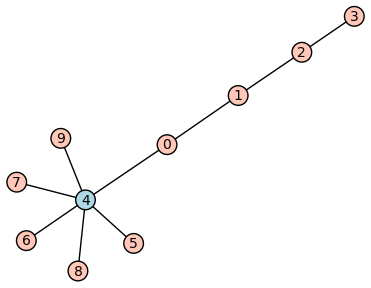

active-vertex-elimination started...


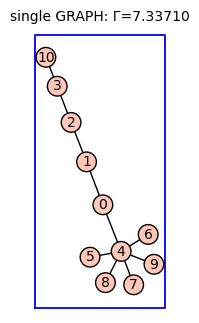

...only one active vertex remained --> adding leaf at vertex #3...
simple-check with active set [3, 10] FAILED for:


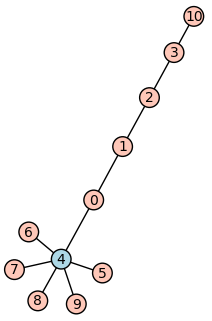

active-vertex-elimination started...


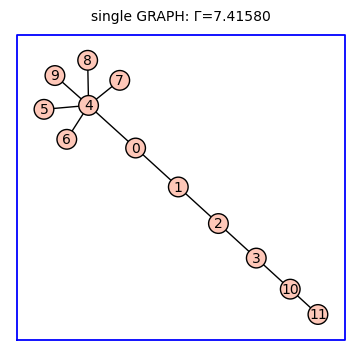

...only one active vertex remained --> adding leaf at vertex #10...
simple-check with active set [10, 11] FAILED for:


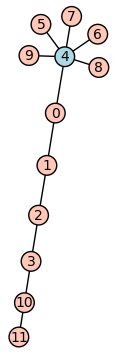

active-vertex-elimination started...


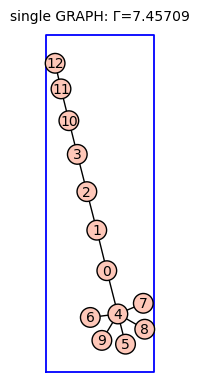

...no active vertex remained!
augment-check SUCCESSFUL
-------------------------------------------------------------------
done


In [4]:
#TREES

kernels=generate_kernels(10,only_trees=True)

Ga_target=Ga_tree

cnt=0
for H,root in kernels:
    cnt+=1
    K=Kernel(H,root,Ga_target,tree_mode=True)
    K.default_active()
    K.act_Uc()
    if K.simple_check():
        #print("simple-check SUCCESSFUL for #{}".format(cnt))
        continue
    print("simple-check failed for #{}:".format(cnt))
    K.draw()
    if K.infty_check():
        print("-------------------------------------------------------------------")    
        continue
    print("augment-check with active set {} started...".format(K.active))    
    K.augment_check()
    print("-------------------------------------------------------------------")    

    
print("done")


## Computer checks for connected graphs
The next code performs the checks for ruling out all but one 6-kernel of connected graphs $G$ with $\Gamma_{G}<\Gamma_{\mathrm{target}}=5.25$. The default value of `Ga_target` is $5.25$ but one may set it to a slightly higher value to find more families and single graphs below `Ga_target`. 

It runs through all possible 6-kernels (`H`,`root`) of graphs and tries to verify the condition that ensures that $\Gamma_G \geq \Gamma_{\mathrm{target}}$ for all extensions $G$ of the kernel. If it fails, it checks whether an infinite pendant path may be attached to `H` such that $\Gamma_{H+P_\infty}<\Gamma_{\mathrm{target}}$. If yes, then there is an infinite family of graphs $G$ with $\Gamma_{G}<\Gamma_{\mathrm{target}}$. If no, then it tries the two-step verification (see the paper). At this point it may find single graphs $G$ with $\Gamma_{G}<\Gamma_{\mathrm{target}}$.

If `diag_only` is set to `True`, then it only checks the condition for pairs $U=V$ making the running time faster. In theory, it could mean that it doesn't catch a failed condition for some $U \neq V$ but it appears that if the condition holds for diagonal pairs, then it holds for all pairs.

155 rooted graphs found on 6 vertices
simple-check failed for #28:


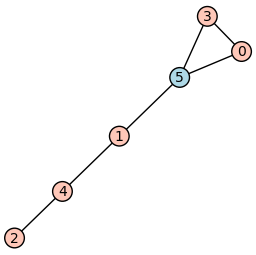

two-step-check excluding #2 vertex started...
SUCCESSFUL
-------------------------------------------------------------------
simple-check failed for #34:


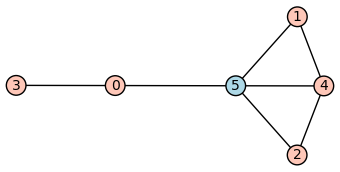

two-step-check excluding #3 vertex started...
SUCCESSFUL
-------------------------------------------------------------------
simple-check failed for #104:


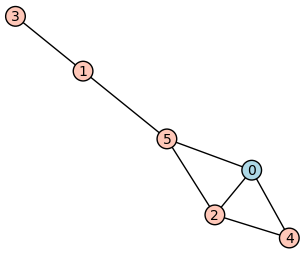

two-step-check excluding #3 vertex started...


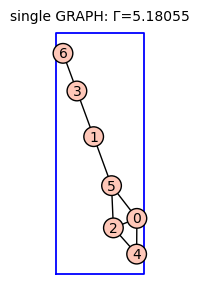

SUCCESSFUL
-------------------------------------------------------------------
simple-check failed for #105:


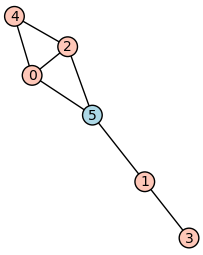

two-step-check excluding #3 vertex started...


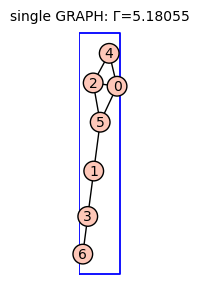

SUCCESSFUL
-------------------------------------------------------------------
simple-check failed for #109:


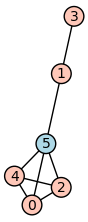

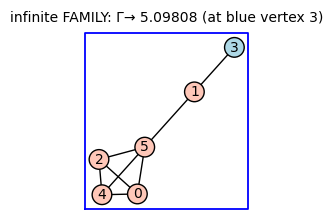

done


In [5]:
#CONNECTED GRAPHS

kernels=generate_kernels(6)

Ga_target=5.25
diag_only=False
# use 'True' to speed things up (warning: with 'True' the proof is not completely rigorous!)
#diag_only=True  

cnt=0
for H,root in kernels:
    cnt+=1
    K=Kernel(H,root,Ga_target)
    K.default_active()
    K.act_Uc()
    if K.simple_check(diag_only):
        continue
    print("simple-check failed for #{}:".format(cnt))
    K.draw()
    if K.infty_check():
        continue
        print("-------------------------------------------------------------------")    
    K.two_step_check()
    print("-------------------------------------------------------------------")    

    
print("done")

## Details of the computer check: $K_3+P_3$

Details are displayed for the computer check for a specific kernel. In this example, the kernel is the following: $H=K_3+P_3$; $o$ is the vertex of degree $3$, and the target ratio is $\Gamma_{\mathrm{target}}=\beta=5+\frac{1}{4}$. All the necessary computations are displayed. In the end, for each pair $U,V$ the polynomials $Q$ and $\tilde{Q}$ are computed and the coefficient check is performed. (In this case the check fails for the pair $U=V=\{5\}$.) <b>See the Appendix of the paper</b> for more details on what is displayed here.

One may set `H` to be any $6$-vertex connected graph with a distinguished vertex `root` and some target ratio `Ga_target`.

kernel:


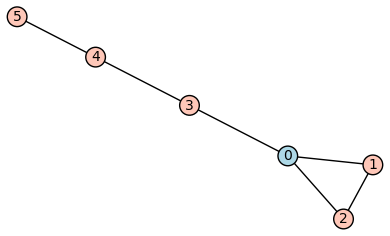

Gamma_target: 21/4
adjacency matrix:
[0 1 1 1 0 0]
[1 0 1 0 0 0]
[1 1 0 0 0 0]
[1 0 0 0 1 0]
[0 0 0 1 0 1]
[0 0 0 0 1 0]

P(λ)= λ^6 - 6*λ^4 - 2*λ^3 + 8*λ^2 + 4*λ - 1 

P(λ)B(λ):
(λ^5 - 3*λ^3 + 2*λ, λ^4 + λ^3 - 2*λ^2 - 2*λ, λ^4 + λ^3 - 2*λ^2 - 2*λ, λ^4 - 2*λ^2 + 1, λ^3 - λ, λ^2 - 1)
(λ^4 + λ^3 - 2*λ^2 - 2*λ, λ^5 - 4*λ^3 + 3*λ, λ^4 + λ^3 - 3*λ^2 - 2*λ + 1, λ^3 + λ^2 - λ - 1, λ^2 + λ, λ + 1)
(λ^4 + λ^3 - 2*λ^2 - 2*λ, λ^4 + λ^3 - 3*λ^2 - 2*λ + 1, λ^5 - 4*λ^3 + 3*λ, λ^3 + λ^2 - λ - 1, λ^2 + λ, λ + 1)
(λ^4 - 2*λ^2 + 1, λ^3 + λ^2 - λ - 1, λ^3 + λ^2 - λ - 1, λ^5 - 4*λ^3 - 2*λ^2 + 3*λ + 2, λ^4 - 3*λ^2 - 2*λ, λ^3 - 3*λ - 2)
(λ^3 - λ, λ^2 + λ, λ^2 + λ, λ^4 - 3*λ^2 - 2*λ, λ^5 - 4*λ^3 - 2*λ^2 + λ, λ^4 - 4*λ^2 - 2*λ + 1)
(λ^2 - 1, λ + 1, λ + 1, λ^3 - 3*λ - 2, λ^4 - 4*λ^2 - 2*λ + 1, λ^5 - 5*λ^3 - 2*λ^2 + 4*λ + 2)

active vertices: [4, 5]
possible subsets: [[4], [5], [4, 5]]
la_H for kernel: 2.2283

U: [4]    λ_U: 2.2533
P B~_o,U: λ^3 - λ
P s_U: λ^5 + 2*λ^4 - 3*λ^3 - 7*λ^2 - 2*λ + 1
------------------

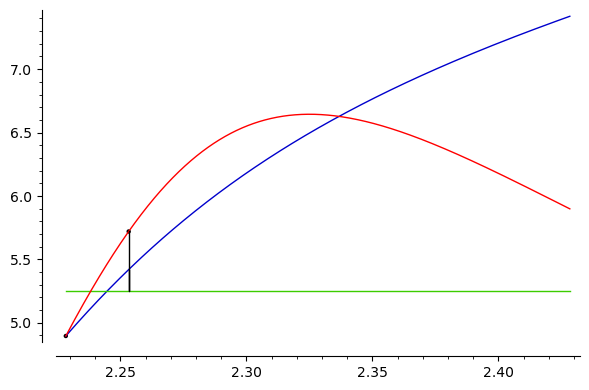

U=[4]   V=[5]   λ~: 2.2533
P^2 c_U,V: 2*λ^9 - 16*λ^7 - 8*λ^6 + 38*λ^5 + 32*λ^4 - 12*λ^3 - 6*λ^2 + 8*λ + 2 

Q(λ)= λ^12 + 2*λ^11 - 8*λ^10 - 265/8*λ^9 + 83/8*λ^8 + 1299/8*λ^7 + 693/8*λ^6 - 281*λ^5 - 517/2*λ^4 + 615/8*λ^3 + 613/8*λ^2 - 257/8*λ - 105/8 

Q~(κ)=Q(λ+λ~)= κ^12 + 29.03925928287372*κ^11 + 376.66934902823516*κ^10 + 2861.9935530867588*κ^9 + 14046.397198219627*κ^8 + 46329.41592340416*κ^7 + 103588.62346877414*κ^6 + 154664.12843342888*κ^5 + 148175.3222840991*κ^4 + 84959.69131658977*κ^3 + 26630.49335106064*κ^2 + 4425.267859089223*κ + 59.96846221995514 

simple-check SUCCESSFUL


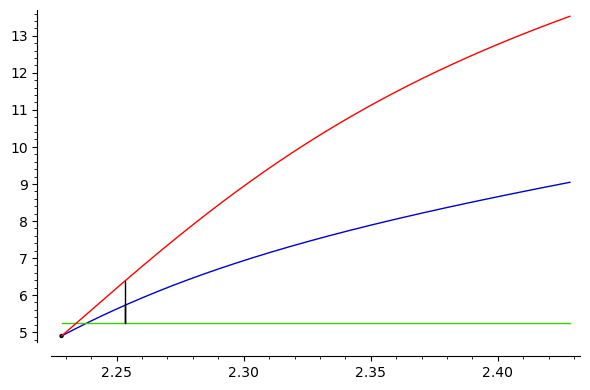

U=[4]   V=[4, 5]   λ~: 2.3429
P^2 c_U,V: λ^10 + 2*λ^9 - 6*λ^8 - 20*λ^7 - 3*λ^6 + 46*λ^5 + 55*λ^4 + 16*λ^3 - 2*λ^2 + 4*λ + 3 

Q(λ)= λ^12 + 3*λ^11 - 41/4*λ^10 - 163/4*λ^9 + 151/8*λ^8 + 783/4*λ^7 + 893/8*λ^6 - 1259/4*λ^5 - 402*λ^4 - 135/2*λ^3 + 505/8*λ^2 - 47/4*λ - 147/8 

Q~(κ)=Q(λ+λ~)= κ^12 + 31.115076993326028*κ^11 + 429.35950747111144*κ^10 + 3454.2487970061266*κ^9 + 17909.34221976818*κ^8 + 62422.03198460888*κ^7 + 148022.60012261305*κ^6 + 236521.12476929664*κ^5 + 247603.7115774412*κ^4 + 163258.30633828632*κ^3 + 66590.17452718689*κ^2 + 17078.896444477286*κ + 1176.6933613132878 

simple-check SUCCESSFUL


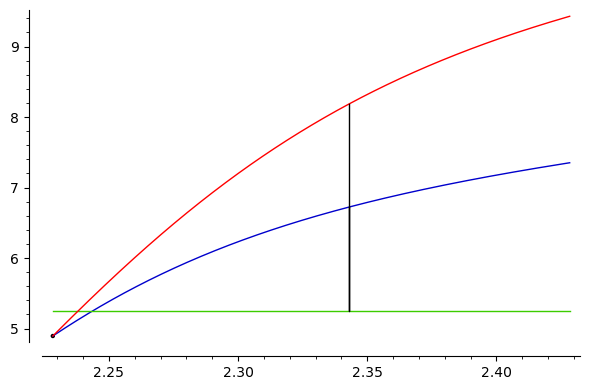

U=[5]   V=[5]   λ~: 2.2332
P^2 c_U,V: λ^10 - 9*λ^8 - 4*λ^7 + 26*λ^6 + 20*λ^5 - 23*λ^4 - 24*λ^3 + 13*λ^2 + 28*λ + 12 

Q(λ)= λ^12 + 2*λ^11 - 57/4*λ^10 - 22*λ^9 + 61*λ^8 + 97*λ^7 - 327/4*λ^6 - 357/2*λ^5 - 55/4*λ^4 + 225/2*λ^3 + 10*λ^2 - 116*λ - 269/4 

Q~(κ)=Q(λ+λ~)= κ^12 + 28.798514516691725*κ^11 + 364.03745091871434*κ^10 + 2658.616369800499*κ^9 + 12407.991417943844*κ^8 + 38599.443444564786*κ^7 + 80880.76057679139*κ^6 + 112535.6834126695*κ^5 + 99776.83685068696*κ^4 + 52219.62758726439*κ^3 + 14485.75471957297*κ^2 + 2162.8081054635218*κ - 5.536431163598557 

simple-check FAILED


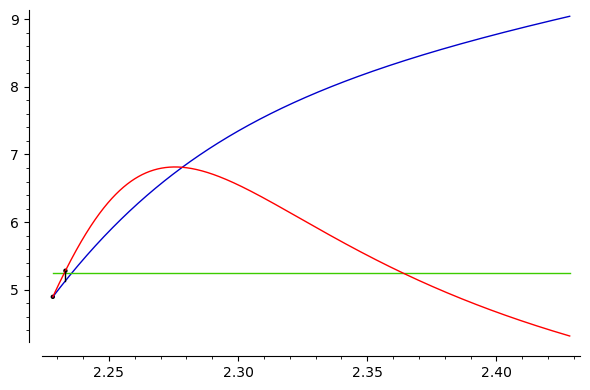

U=[5]   V=[4, 5]   λ~: 2.3429
P^2 c_U,V: λ^10 + 2*λ^9 - 9*λ^8 - 20*λ^7 + 18*λ^6 + 58*λ^5 + 9*λ^4 - 36*λ^3 + 7*λ^2 + 36*λ + 14 

Q(λ)= λ^12 + 3*λ^11 - 45/4*λ^10 - 329/8*λ^9 + 35*λ^8 + 1571/8*λ^7 + 57/2*λ^6 - 1439/4*λ^5 - 449/2*λ^4 + 1193/8*λ^3 + 38*λ^2 - 1261/8*λ - 307/4 

Q~(κ)=Q(λ+λ~)= κ^12 + 31.115076993326028*κ^11 + 428.35950747111144*κ^10 + 3430.4445661783543*κ^9 + 17670.54186863235*κ^8 + 61107.47095821744*κ^7 + 143695.2376076635*κ^6 + 227778.74974903936*κ^5 + 236631.9998576858*κ^4 + 153981.70740789047*κ^3 + 60092.35072575025*κ^2 + 13901.6890347455*κ + 948.1740981633329 

simple-check SUCCESSFUL


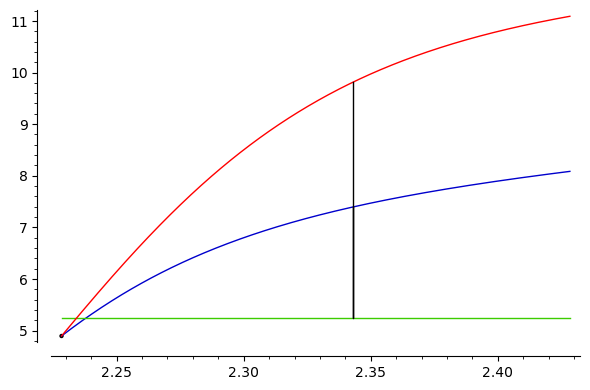

U=[4, 5]   V=[4, 5]   λ~: 2.3429
P^2 c_U,V: 2*λ^10 + 4*λ^9 - 15*λ^8 - 40*λ^7 + 15*λ^6 + 104*λ^5 + 64*λ^4 - 20*λ^3 + 5*λ^2 + 40*λ + 17 

Q(λ)= λ^12 + 4*λ^11 - 25/2*λ^10 - 225/4*λ^9 + 77/2*λ^8 + 1163/4*λ^7 + 179/2*λ^6 - 547*λ^5 - 491*λ^4 + 243/4*λ^3 + 35*λ^2 - 729/4*λ - 181/2 

Q~(κ)=Q(λ+λ~)= κ^12 + 32.11507699332603*κ^11 + 452.8816613816603*κ^10 + 3687.943899093194*κ^9 + 19168.400830806586*κ^8 + 66293.03841986635*κ^7 + 154208.48694075222*κ^6 + 238603.01201451704*κ^5 + 238983.42578506278*κ^4 + 151711.42760258802*κ^3 + 65221.813308352146*κ^2 + 21084.74030903487*κ + 1586.9888217094888 

simple-check SUCCESSFUL


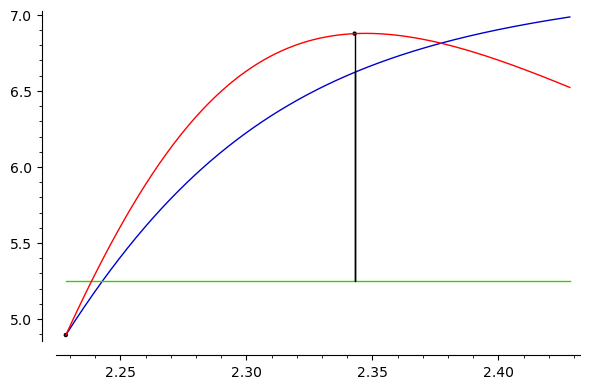

In [6]:
H=graphs.CompleteGraph(3)
add_path(H,3,0)
root=0
Ga_target=5+1/4

K=Kernel(H,root,Ga_target)
K.default_active()
K.act_Uc()
K.detailed_check()

## Details the computer check: $S_4+P_6$

Another example. This time a 10-kernel is checked in detail: $H=S_4+P_6$; $o$ is the vertex of degree $4$, and the target ratio is $\Gamma_{\mathrm{target}}=\beta=\beta_{\mathrm{tr}}$.

kernel:


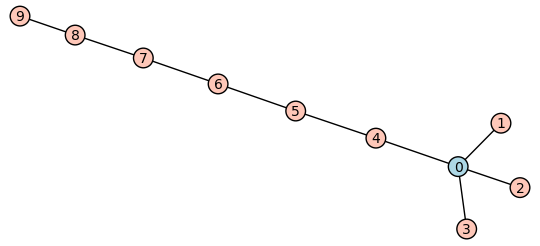

Gamma_target: 7.46410161513775
adjacency matrix:
[0 1 1 1 1 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 1 0 0 0 0]
[0 0 0 0 1 0 1 0 0 0]
[0 0 0 0 0 1 0 1 0 0]
[0 0 0 0 0 0 1 0 1 0]
[0 0 0 0 0 0 0 1 0 1]
[0 0 0 0 0 0 0 0 1 0]

P(λ)= λ^10 - 9*λ^8 + 25*λ^6 - 22*λ^4 + 3*λ^2 

P(λ)B(λ):
(λ^9 - 5*λ^7 + 6*λ^5 - λ^3, λ^8 - 5*λ^6 + 6*λ^4 - λ^2, λ^8 - 5*λ^6 + 6*λ^4 - λ^2, λ^8 - 5*λ^6 + 6*λ^4 - λ^2, λ^8 - 4*λ^6 + 3*λ^4, λ^7 - 3*λ^5 + λ^3, λ^6 - 2*λ^4, λ^5 - λ^3, λ^4, λ^3)
(λ^8 - 5*λ^6 + 6*λ^4 - λ^2, λ^9 - 8*λ^7 + 20*λ^5 - 16*λ^3 + 2*λ, λ^7 - 5*λ^5 + 6*λ^3 - λ, λ^7 - 5*λ^5 + 6*λ^3 - λ, λ^7 - 4*λ^5 + 3*λ^3, λ^6 - 3*λ^4 + λ^2, λ^5 - 2*λ^3, λ^4 - λ^2, λ^3, λ^2)
(λ^8 - 5*λ^6 + 6*λ^4 - λ^2, λ^7 - 5*λ^5 + 6*λ^3 - λ, λ^9 - 8*λ^7 + 20*λ^5 - 16*λ^3 + 2*λ, λ^7 - 5*λ^5 + 6*λ^3 - λ, λ^7 - 4*λ^5 + 3*λ^3, λ^6 - 3*λ^4 + λ^2, λ^5 - 2*λ^3, λ^4 - λ^2, λ^3, λ^2)
(λ^8 - 5*λ^6 + 6*λ^4 - λ^2, λ^7 - 5*λ^5 + 6*λ^3 - λ, λ^7 - 5*λ^5 + 6*λ^3 - λ, λ^9 - 8*λ^7 + 20*λ^5 - 16*λ^3 + 2*

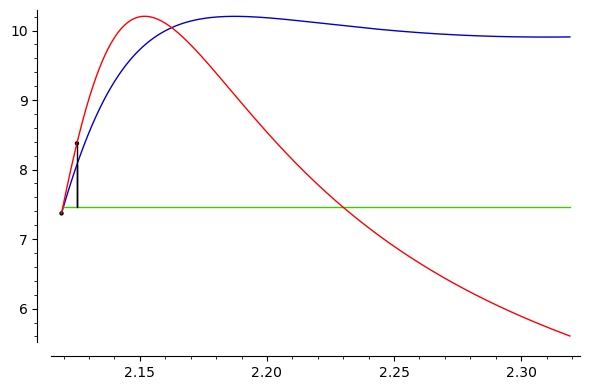

U=[8]   V=[9]   λ~: 2.1252
P^2 c_U,V: 2*λ^17 - 28*λ^15 + 148*λ^13 - 368*λ^11 + 436*λ^9 - 216*λ^7 + 60*λ^5 

Q(λ)= λ^20 + 2.00000000000000*λ^19 - 14.0000000000000*λ^18 - 42.9282032302755*λ^17 + 75.0000000000000*λ^16 + 358.994845223857*λ^15 - 197.732050807569*λ^14 - 1494.41908984796*λ^13 + 289.588457268120*λ^12 + 3272.37785163881*λ^11 - 270.301270189222*λ^10 - 3633.64957438928*λ^9 + 157.105117766515*λ^8 + 1754.35106663627*λ^7 - 29.1961524227066*λ^6 - 459.042249330972*λ^5 

Q~(κ)=Q(λ+λ~)= κ^20 + 44.50449302109845*κ^19 + 924.9087020558754*κ^18 + 11908.756796088126*κ^17 + 106287.45676079097*κ^16 + 697173.9515210544*κ^15 + 3477200.7868563915*κ^14 + 13460304.210502632*κ^13 + 40921948.47542086*κ^12 + 98249460.71401562*κ^11 + 186339978.23491243*κ^10 + 277900749.68529356*κ^9 + 322734563.5886557*κ^8 + 287287001.8005636*κ^7 + 191483195.76651704*κ^6 + 92421850.53333169*κ^5 + 30861232.638774693*κ^4 + 6759843.014298584*κ^3 + 951656.046221189*κ^2 + 89567.17173047128*κ + 462.4963886095495 

simple-chec

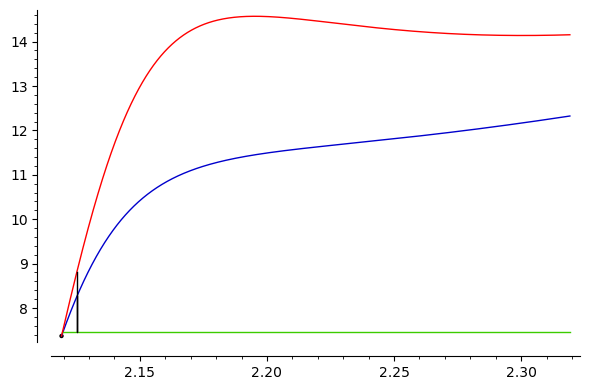

U=[9]   V=[9]   λ~: 2.1203
P^2 c_U,V: λ^18 - 15*λ^16 + 87*λ^14 - 246*λ^12 + 351*λ^10 - 234*λ^8 + 58*λ^6 + 30*λ^4 

Q(λ)= λ^20 + 2.00000000000000*λ^19 - 22.4641016151378*λ^18 - 30.0000000000000*λ^17 + 199.961524227066*λ^16 + 176.000000000000*λ^15 - 906.376840516985*λ^14 - 521.464101615138*λ^13 + 2233.16899732389*λ^12 + 859.176914536240*λ^11 - 2946.89966691335*λ^10 - 820.602540378444*λ^9 + 1900.59977794223*λ^8 + 410.210235533031*λ^7 - 480.917893677990*λ^6 - 58.3923048454133*λ^5 - 214.923048454133*λ^4 

Q~(κ)=Q(λ+λ~)= κ^20 + 44.40522447342976*κ^19 + 912.2522796393129*κ^18 + 11516.209518253574*κ^17 + 100055.33249521483*κ^16 + 634901.0250031096*κ^15 + 3046854.72038874*κ^14 + 11295405.549916942*κ^13 + 32755226.60112849*κ^12 + 74756941.185768*κ^11 + 134406602.30872712*κ^10 + 189636717.125055*κ^9 + 208148248.69154727*κ^8 + 175227552.6464969*κ^7 + 110800409.76054816*κ^6 + 51099631.05497426*κ^5 + 16515528.426997336*κ^4 + 3565804.3396193394*κ^3 + 500505.7024068114*κ^2 + 46244.19739141326*κ + 28.0

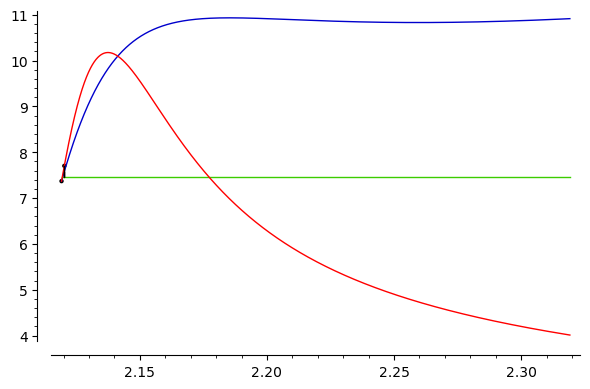

In [7]:
H=graphs.StarGraph(3)
add_path(H,6,0)
root=0

K=Kernel(H,root,tree_mode=True)
K.default_active()
K.act_Uc()
K.detailed_check()

## Ruling out early branching of the tail

The following checks need to be performed so that we can conclude that for the optimal graphs/trees the tail cannot branch at an early stage (for $k=1,2,3,4$ in case of $K_4$ and for $k=4,5,6,7,8,9$ in case of $S_5$).

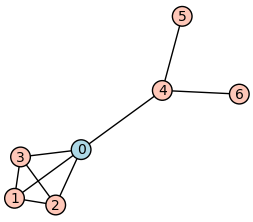

5.253366635036475 > 5.09807621135332 True
extensions > 5.09807621135332: True


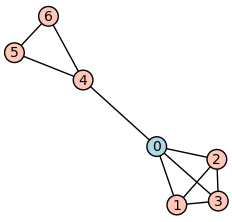

5.650358998310009 > 5.09807621135332 True
extensions > 5.09807621135332: True


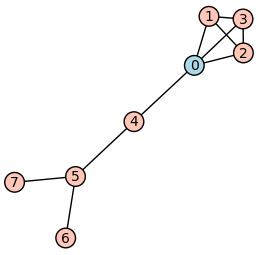

5.185723026975163 > 5.09807621135332 True
extensions > 5.09807621135332: True


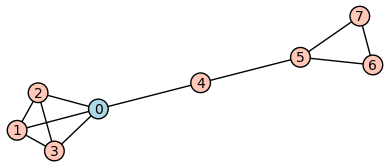

5.401048813930225 > 5.09807621135332 True
extensions > 5.09807621135332: True


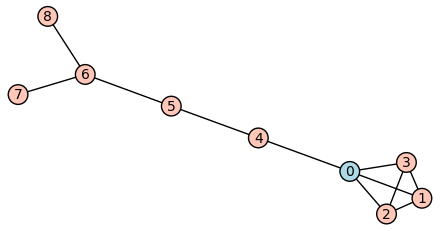

5.135875368905642 > 5.09807621135332 True
extensions > 5.09807621135332: True


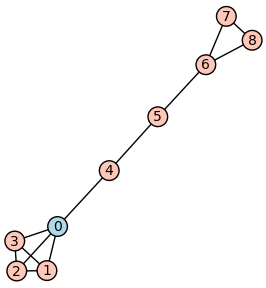

5.225993890568771 > 5.09807621135332 True
extensions > 5.09807621135332: True


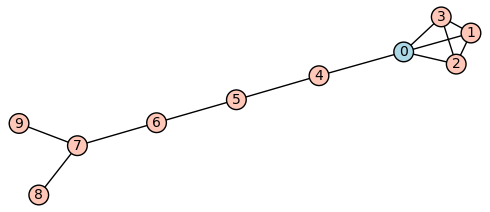

5.11287759447238 > 5.09807621135332 True
extensions > 5.09807621135332: True


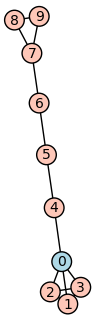

5.147565461689356 > 5.09807621135332 True
extensions > 5.09807621135332: True


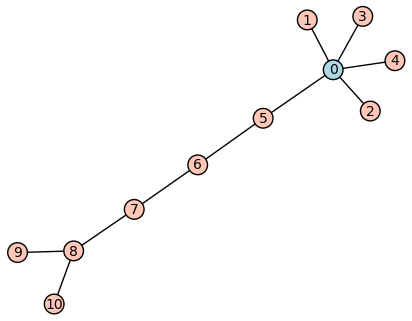

7.5205180526448485 > 7.46410161513775 True
extensions > 7.46410161513775: True


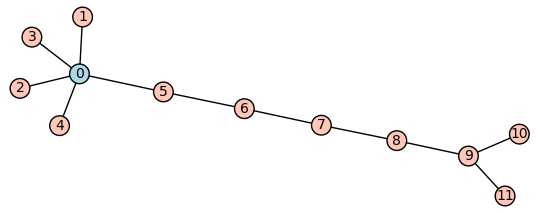

7.5303373741042 > 7.46410161513775 True
extensions > 7.46410161513775: True


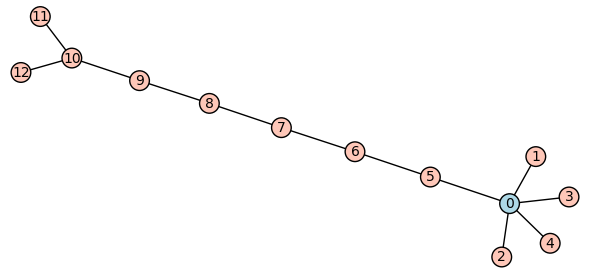

7.51605193420664 > 7.46410161513775 True
extensions > 7.46410161513775: True


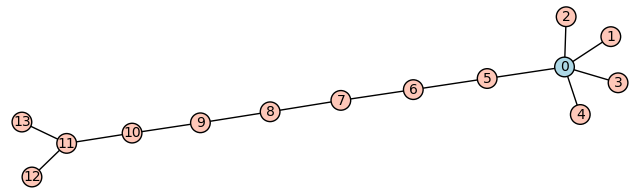

7.499426995260411 > 7.46410161513775 True
extensions > 7.46410161513775: True


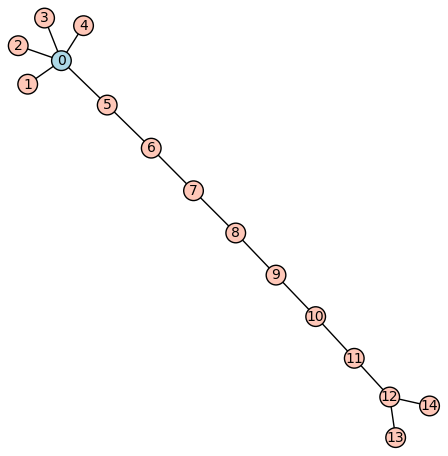

7.486518783951552 > 7.46410161513775 True
extensions > 7.46410161513775: True


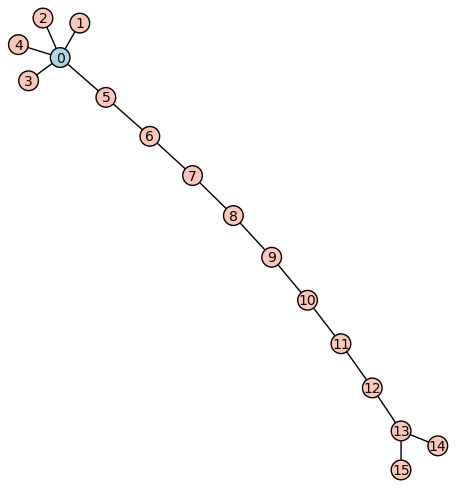

7.477798928715708 > 7.46410161513775 True
extensions > 7.46410161513775: True


In [8]:
for k in [1,2,3,4]:
    tail_check_upper_small(graphs.CompleteGraph(4),k)
    tail_check_upper_small(graphs.CompleteGraph(4),k,triangle=True)
    
for k in [4,5,6,7,8,9]:
    tail_check_upper_small(graphs.StarGraph(4),k,tree_mode=True)


## Checking the conditions of Lemma 7.5

In the relevant special cases $H=K_4$ and $H=S_5$. 

One may try it for any $H,v,k_0$.

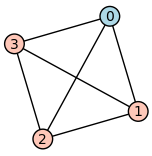

the relevant interval for λ: I=(3.0861,3.0981)
S(λ)= 1/(λ - 3)
S^(t)= t/(t^2 - 3*t + 1)

T(λ)= (λ^2 - 4*λ + 7)/(λ^4 - 4*λ^3 - 2*λ^2 + 12*λ + 9)
T^(t)= (t^6 - 4*t^5 + 9*t^4 - 4*t^3 + t^2)/(t^8 - 4*t^7 + 2*t^6 + 11*t^4 + 2*t^2 - 4*t + 1)

J^(t)= (t^7 - t^6 - 3*t^5 - 3*t^4 + 3*t^3 + 9*t^2 + 8*t + 4)/(t^7 - 5*t^6 + 7*t^5 - 7*t^4 + 23*t^3 - 19*t^2 - 6*t + 6)
J(λ)=J^(r(λ)) should be monotone increasing on I:


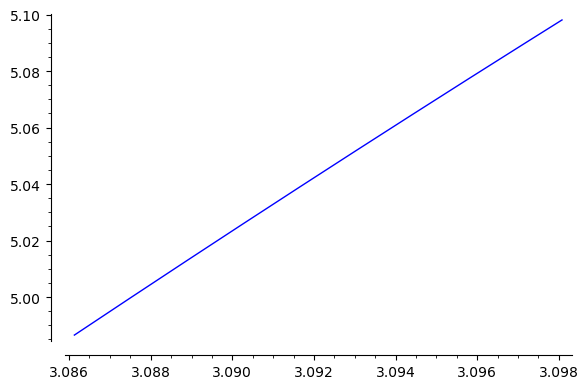

f^(t)=(T^(t)+1)t-S^(t)-t/(t-1)= (t^10 - 6*t^9 + 10*t^8 - 7*t^7 + 25*t^6 - 32*t^5 + 4*t^4 - 10*t^3 + 7*t^2 - t)/(t^9 - 5*t^8 + 6*t^7 - 2*t^6 + 11*t^5 - 11*t^4 + 2*t^3 - 6*t^2 + 5*t - 1)
f(λ)=f^(r(λ)) should be positive on I:


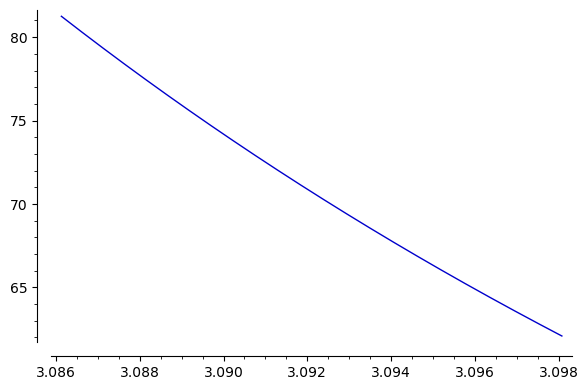

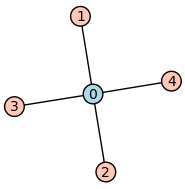

the relevant interval for λ: I=(2.2361,2.3094)
S(λ)= (λ + 4)/(λ^2 - 4)
S^(t)= (t^3 + 4*t^2 + t)/(t^4 - 2*t^2 + 1)

T(λ)= (λ^2 + 4)/(λ^4 - 8*λ^2 + 16)
T^(t)= (t^6 + 6*t^4 + t^2)/(t^8 - 4*t^6 + 6*t^4 - 4*t^2 + 1)

J^(t)= (t^4 + 4*t^3 + 10*t^2 + 12*t + 9)/(t^4 - 2*t^2 + 9)
J(λ)=J^(r(λ)) should be monotone increasing on I:


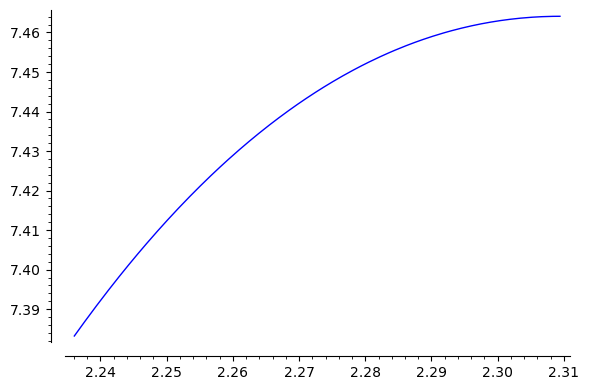

f^(t)=(T^(t)+1)t-S^(t)-t/(t-1)= (t^9 - t^8 - 5*t^7 - t^6 + 16*t^5 + 5*t^4 - 5*t^3 - 3*t^2 + t)/(t^8 - 4*t^6 + 6*t^4 - 4*t^2 + 1)
f(λ)=f^(r(λ)) should be positive on I:


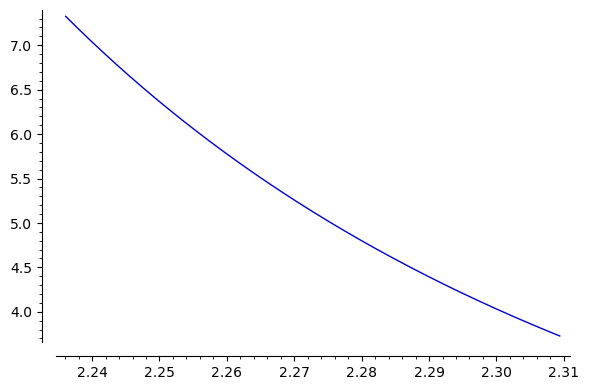

In [9]:
K=Kernel(graphs.CompleteGraph(4),0)
K.draw()
K.tail_check_lower()

K=K=Kernel(graphs.StarGraph(4),0)
K.draw()
K.tail_check_lower()

#K=K=Kernel(graphs.StarGraph(5),1)
#K.draw()
#K.tail_check_lower()


## Ranking for graphs

For each $3 \leq n \leq 6$, the $n$-vertex connected graphs $G$ are ranked in increasing order of their $\Gamma_G$ values. For each $n$, the first `display_nr` graphs are displayed. 

3-vertex connected graphs with the smallest Gamma:


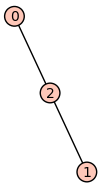

2.9142135623730954


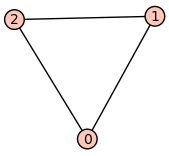

3.0000000000000004
---------------------------------------------------------
4-vertex connected graphs with the smallest Gamma:


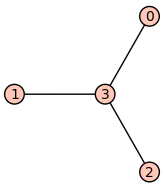

3.732050807568878


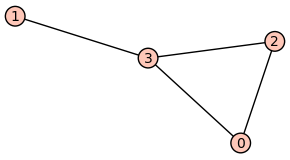

3.7593917940847903


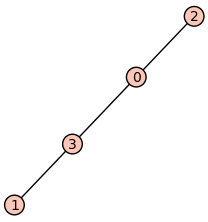

3.788854381999831
---------------------------------------------------------
5-vertex connected graphs with the smallest Gamma:


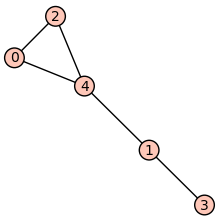

4.389714587059625


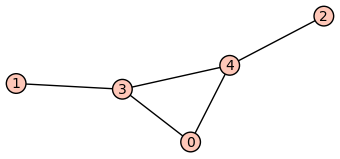

4.459684085530045


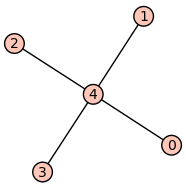

4.5
---------------------------------------------------------
6-vertex connected graphs with the smallest Gamma:


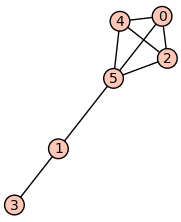

4.877797842118119


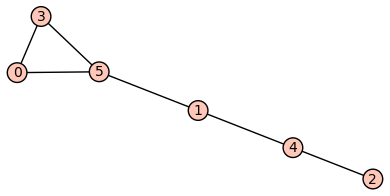

4.895005491356103


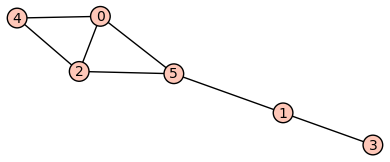

4.955687391836362
---------------------------------------------------------


In [10]:
for n in range(3,7):
    #ranking(n)
    ranking(n,display_nr=3)

## Ranking for trees

For each $3 \leq n \leq 14$, the $n$-vertex trees $T$ are ranked in increasing order of their $\Gamma_T$ values. For each $n$, the first `display_nr` trees are displayed. 

3-vertex trees with the smallest Gamma:


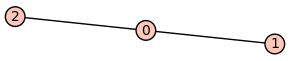

2.9142135623730954
---------------------------------------------------------
4-vertex trees with the smallest Gamma:


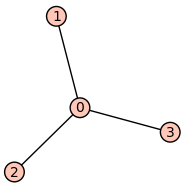

3.7320508075688767


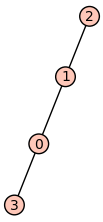

3.788854381999831
---------------------------------------------------------
5-vertex trees with the smallest Gamma:


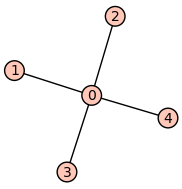

4.5


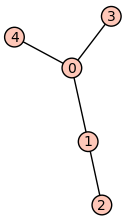

4.541102669167484


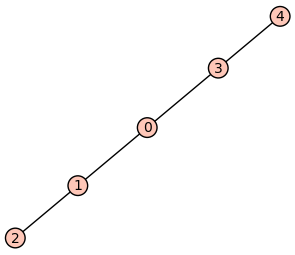

4.642734410091836
---------------------------------------------------------
6-vertex trees with the smallest Gamma:


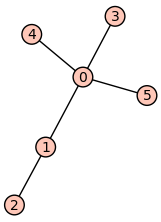

5.22350957639338


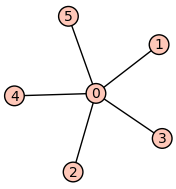

5.236067977499789


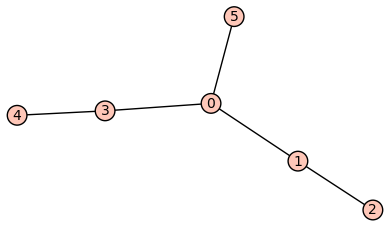

5.293658972143935
---------------------------------------------------------
7-vertex trees with the smallest Gamma:


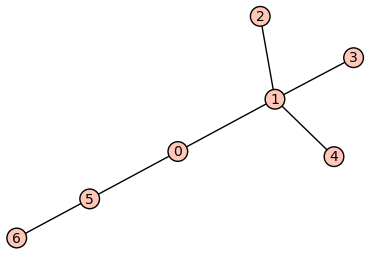

5.881694863254863


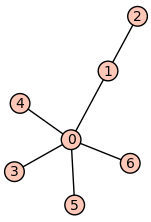

5.882568811815309


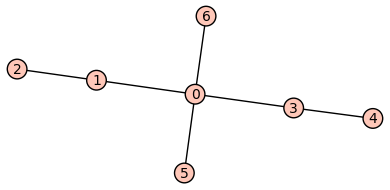

5.904210539519947
---------------------------------------------------------
8-vertex trees with the smallest Gamma:


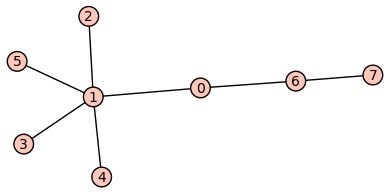

6.3963400117332565


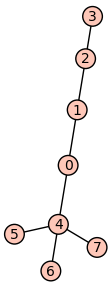

6.4618222097141755


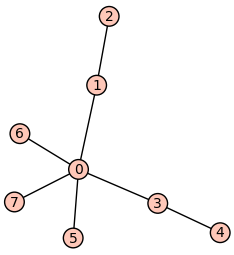

6.502117353535855
---------------------------------------------------------
9-vertex trees with the smallest Gamma:


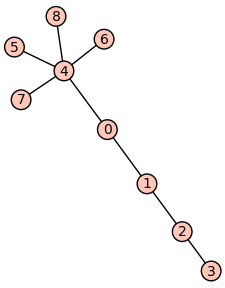

6.773303701351204


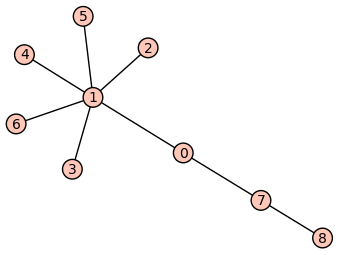

6.93935762169527


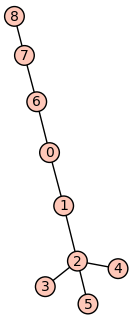

6.957939992519059
---------------------------------------------------------
10-vertex trees with the smallest Gamma:


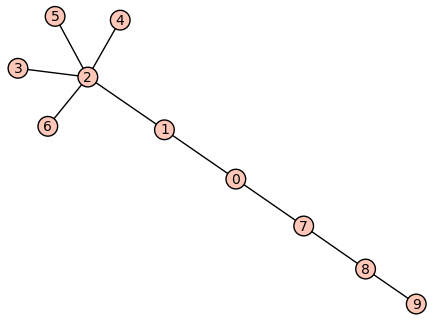

7.032163840259049


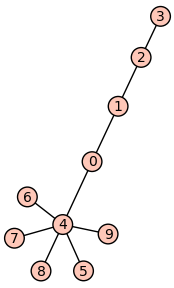

7.192164564163829


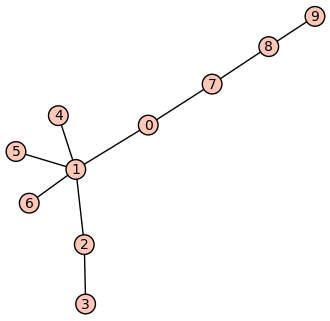

7.334567058552956
---------------------------------------------------------
11-vertex trees with the smallest Gamma:


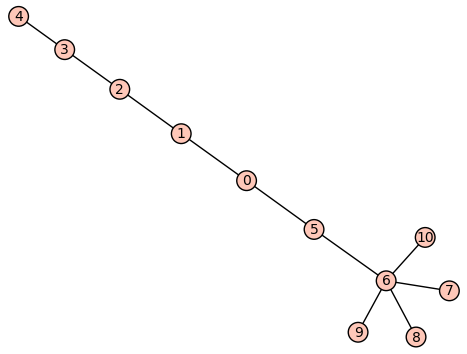

7.200853043167128


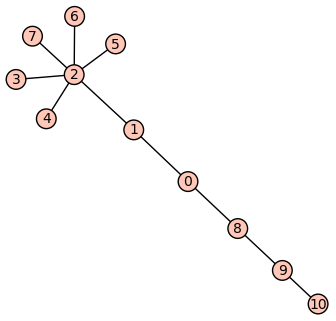

7.337103236229094


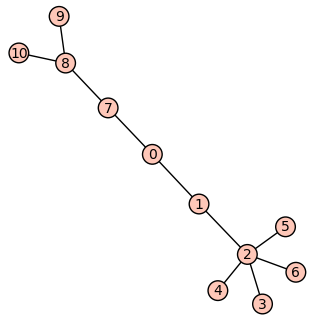

7.520518052644845
---------------------------------------------------------
12-vertex trees with the smallest Gamma:


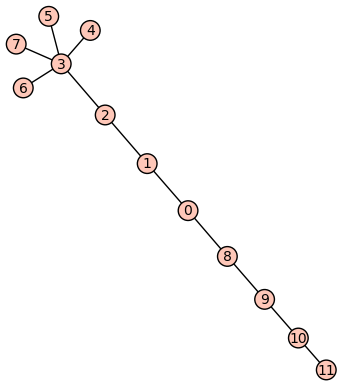

7.306568687524058


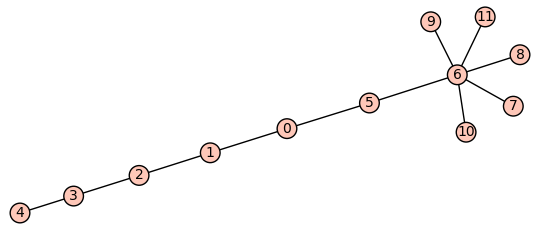

7.415799301908253


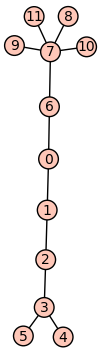

7.530337374104205
---------------------------------------------------------
13-vertex trees with the smallest Gamma:


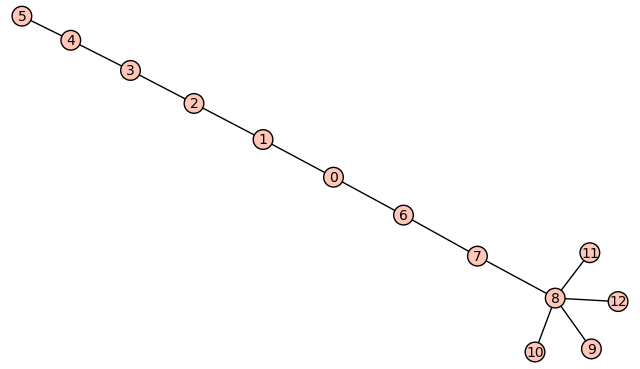

7.3710061054096325


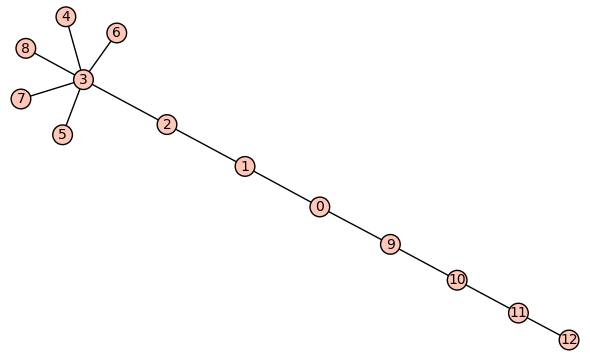

7.457090621681225


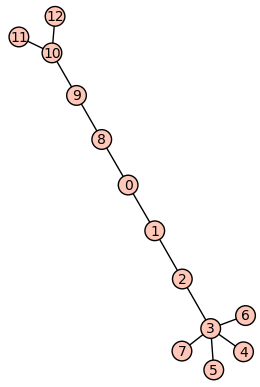

7.516051934206638
---------------------------------------------------------


In [11]:
for n in range(3,14):
    #ranking(n,only_trees=True)
    ranking(n,only_trees=True,display_nr=3)

## Graphs with top eigenvalue at most $2$

$\Gamma_G$ is computed for the four families of graphs and the six sporadic graphs for which $\lambda_G \leq 2$.

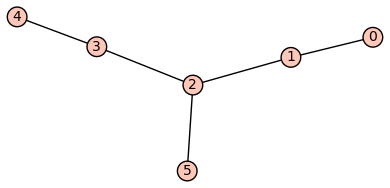

5.293658972143936


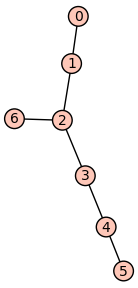

6.043666168796509


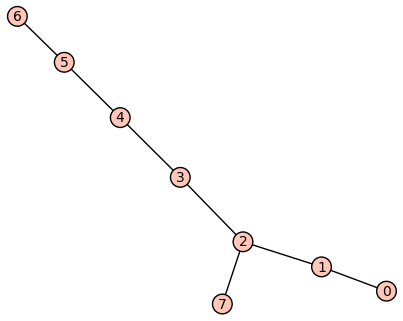

6.7810597700467925


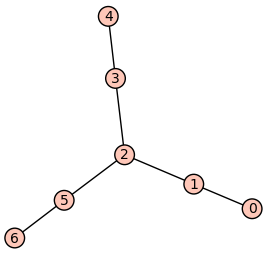

6.000000000000002


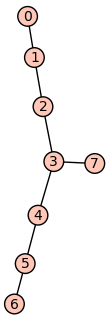

6.75


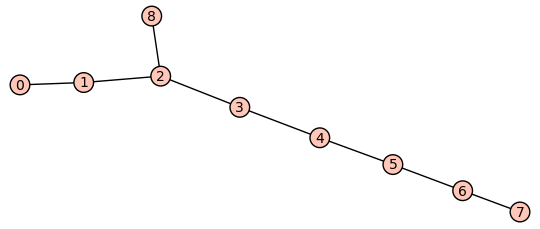

7.499999999999998


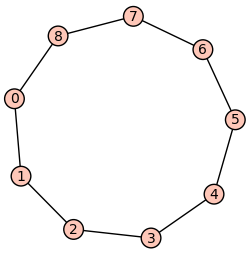

9.0


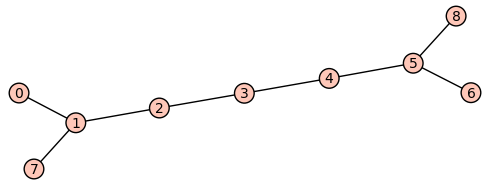

8.166666666666668


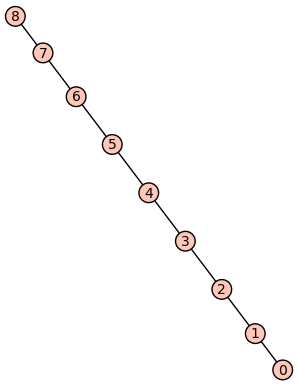

7.97269163781228


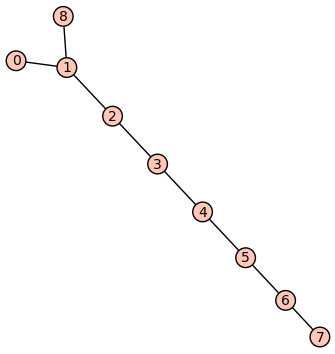

7.774575605939696
\nGamma_G for the 4 families (C_n  \hat{D}_n  P_n  D_n):
n= 5:   5.0  4.50000  4.64273  4.54110
n= 6:   6.0  5.33333  5.48448  5.34910
n= 7:   7.0  6.25000  6.31854  6.15725
n= 8:   8.0  7.20000  7.14743  6.96575
n= 9:   9.0  8.16667  7.97269  7.77458
n=10:   10.0  9.14286  8.79530  8.58368
n=11:   11.0  10.12500  9.61591  9.39300
n=12:   12.0  11.11111  10.43499  10.20251
n=13:   13.0  12.10000  11.25285  11.01216
n=14:   14.0  13.09091  12.06975  11.82192
n=15:   15.0  14.08333  12.88586  12.63179
n=16:   16.0  15.07692  13.70132  13.44174
n=17:   17.0  16.07143  14.51623  14.25175
n=18:   18.0  17.06667  15.33069  15.06182
n=19:   19.0  18.06250  16.14476  15.87194
n=20:   20.0  19.05882  16.95850  16.68211
n=21:   21.0  20.05556  17.77195  17.49231
n=22:   22.0  21.05263  18.58515  18.30254
n=23:   23.0  22.05000  19.39814  19.11280
n=24:   24.0  23.04762  20.21092  19.92309
n=25:   25.0  24.04545  21.02354  20.73340
n=26:   26.0  25.04348  21.83601  21.54373
n=27

In [12]:
# graphs G with lambda_G <= 2 and their Gamma_G

E6=graphs.PathGraph(5)
add_leaf(E6,2)

E7=graphs.PathGraph(6)
add_leaf(E7,2)

E8=graphs.PathGraph(7)
add_leaf(E8,2)

Eh8=graphs.PathGraph(8)
add_leaf(Eh8,2)

Eh6=E6.copy()
add_leaf(Eh6,5)

Eh7=graphs.PathGraph(7)
add_leaf(Eh7,3)

for G in [E6,E7,E8,Eh6,Eh7,Eh8,graphs.CycleGraph(9),bifork(9),graphs.PathGraph(9),unifork(9)]:
    draw_graph(G)
    print(GammaG(G))

print(r"\nGamma_G for the 4 families (C_n  \hat{D}_n  P_n  D_n):")
for n in range(5,50):
    Ga_cycle=GammaG(graphs.CycleGraph(n)) # =n
    Ga_bifork=GammaG(bifork(n)) # =(n-2)^2/(n-3)
    Ga_path=GammaG(graphs.PathGraph(n))
    Ga_fork=GammaG(unifork(n))
    print("n={:2d}:   {:.1f}  {:.5f}  {:.5f}  {:.5f}".format(n, Ga_cycle, Ga_bifork, Ga_path, Ga_fork))
    
    
    

## Our bound on $\Gamma_G$ in terms of $\deg_G(o)$

For each $3 \leq d < 60$, our bound $\beta_d$ is computed for graphs for which the master vertex has $d$ neighbors. For $d=3,4,5,6$, we plot the function that needs to be minimized to find $\beta_d$. 

d=3:  3.5963   (6.4641)
d=4:  4.2239   (7.0000)
d=5:  4.7882   (7.4721)
d=6:  5.3053   (7.8990)
d=7:  5.7854   (8.2915)
d=8:  6.2356   (8.6569)
d=9:  6.6609   (9.0000)
d=10:  7.0650   (9.3246)
d=11:  7.4507   (9.6332)
d=12:  7.8205   (9.9282)
d=13:  8.1761   (10.2111)
d=14:  8.5191   (10.4833)
d=15:  8.8507   (10.7460)
d=16:  9.1720   (11.0000)
d=17:  9.4838   (11.2462)
d=18:  9.7871   (11.4853)
d=19:  10.0823   (11.7178)
d=20:  10.3703   (11.9443)
d=21:  10.6514   (12.1652)
d=22:  10.9261   (12.3808)
d=23:  11.1949   (12.5917)
d=24:  11.4581   (12.7980)
d=25:  11.7161   (13.0000)
d=26:  11.9691   (13.1980)
d=27:  12.2174   (13.3923)
d=28:  12.4614   (13.5830)
d=29:  12.7011   (13.7703)
d=30:  12.9369   (13.9545)
d=31:  13.1688   (14.1355)
d=32:  13.3972   (14.3137)
d=33:  13.6221   (14.4891)
d=34:  13.8437   (14.6619)
d=35:  14.0621   (14.8322)
d=36:  14.2775   (15.0000)
d=37:  14.4900   (15.1655)
d=38:  14.6998   (15.3288)
d=39:  14.9068   (15.4900)
d=40:  15.1113   (15.6491)
d=41:  

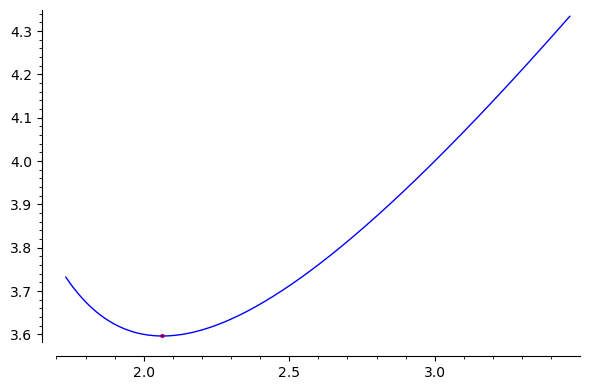

d=4:


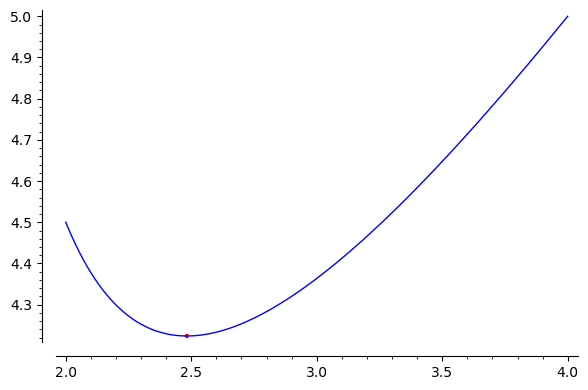

d=5:


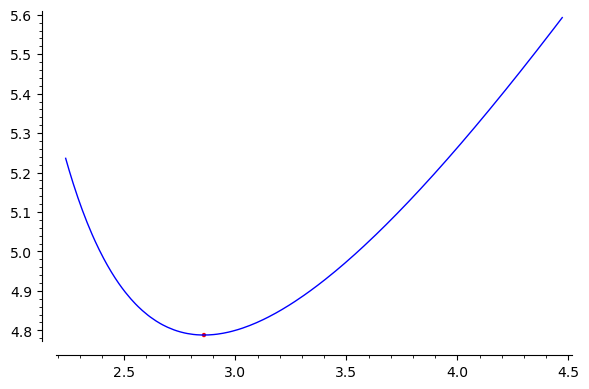

d=6:


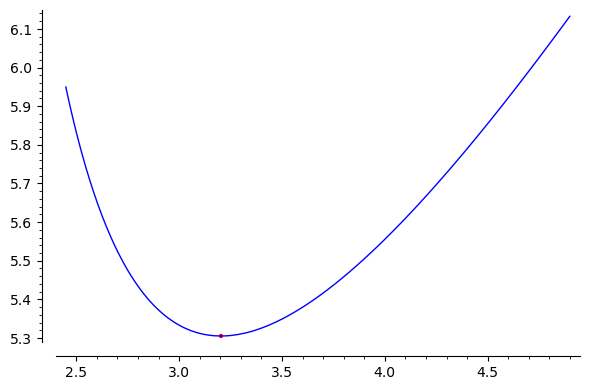

In [13]:
for d in range(3,60):
    print("d={}:  {:.4f}   ({:.4f})".format(d,beta_deg(d),2*sqrt(d+0.)+3))

print()    
for d in range(3,7):
    print("d={}:".format(d))
    beta_deg(d,True)
